In [1]:
from typing import Tuple, Iterable, List
from pprint import pformat
import random
import pickle

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm

In [3]:
from pyproj import Geod, CRS
from shapely.geometry import Point, LineString

In [ ]:
import osmnx as ox
import networkx as nx
from networkx.classes.function import path_weight
import gc
ox.config(use_cache=True, log_console=True)

In [5]:
from itertools import product
from functools import lru_cache

In [124]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.reset_defaults()

plt.style.use("dark_background")

In [7]:
import geojson
import os
import json
from shapely.geometry import mapping
from shapely.geometry.multilinestring import MultiLineString

In [8]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [9]:
GEOD = CRS.from_epsg(4326).get_geod()

## Load WB data

In [259]:
df = pd.read_csv('./simple_cases.csv')
df

,Unnamed: 0,Unnamed: 0.1,id,stretch,route,description of the section,cat stretch,length,cat route,start stage,...,% app,logistic axis name,type final section,Final performance,cost performance final dgc,cost performance final app,app nova via,description,endpoint_1,endpoint_2
0,15,15,16,CA-09-NORTE-01,CA-09-N,PUENTE BELICE - PUENTE RODRIGUITOS,RED PRIMARIA,4.470000,RUTAS CENTROAMERICANAS,3+920,...,1,CPL1,Tipo A+,Ampliar capacidad,0.000000,67.049997,0,puente belice - puente rodriguitos,puente belice,puente rodriguitos
1,18,18,19,CA-09-NORTE-20B,CA-09-N,LA RUIDOSA - BIFURCACION CAYUGA,RED PRIMARIA,14.890000,RUTAS CENTROAMERICANAS,3+920,...,1,CPL1,Tipo A,Ampliar capacidad,0.000000,189.103004,0,la ruidosa - bifurcacion cayuga,la ruidosa,bifurcacion cayuga
2,19,19,20,CA-09-NORTE-21,CA-09-N,BIFURCACION CAYUGA - BIFURCACION EL CIMARRON,RED PRIMARIA,9.800000,RUTAS CENTROAMERICANAS,3+920,...,1,CPL1,Tipo A,Ampliar capacidad,0.000000,158.749978,0,bifurcacion cayuga - bifurcacion el cimarron,bifurcacion cayuga,bifurcacion el cimarron
3,28,28,29,CA-09-SUR-05,CA-09-S1,500 METROS ADELANTE BASCULA DGC - PALIN,RED PRIMARIA,8.950000,RUTAS CENTROAMERICANAS,8+500,...,1,CPL1,Tipo A+,Ampliar capacidad,0.000000,134.249997,0,500 metros adelante bascula dgc - palin,500 metros adelante bascula dgc,palin
4,29,29,30,CA-09-SUR-11,CA-09-S3,PUERTO QUETZAL - PUERTO IZTAPA,RED PRIMARIA,9.750000,RUTAS CENTROAMERICANAS,111+000,...,0,0,Tipo B,Mantenimiento menor,0.390000,0.000000,0,puerto quetzal - puerto iztapa,puerto quetzal,puerto iztapa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,1066,1066,1067,NC_Radial_5,0,Nueva Radial entre anillos - Norte,RED PRIMARIA,8.744591,RUTAS NACIONALES,0,...,0,0,Tipo B,Nueva,104.060630,0.000000,0,nueva radial entre anillos - norte,nueva radial entre anillos,norte
315,1067,1067,1068,NC_Radial_1,0,Nueva Radial entre anillos - Este,RED PRIMARIA,19.935429,RUTAS NACIONALES,0,...,0,0,Tipo B,Nueva,237.231601,0.000000,0,nueva radial entre anillos - este,nueva radial entre anillos,este
316,1068,1068,1069,NC_Radial_2,0,Nueva Radial entre anillos - Sud Este,RED PRIMARIA,26.502766,RUTAS NACIONALES,0,...,0,0,Tipo B,Nueva,315.382911,0.000000,0,nueva radial entre anillos - sud este,nueva radial entre anillos,sud este
317,1069,1069,1070,NC_Radial_3,0,Nueva Radial entre anillos - Sud,RED PRIMARIA,22.825891,RUTAS NACIONALES,0,...,0,0,Tipo B,Nueva,271.628109,0.000000,0,nueva radial entre anillos - sud,nueva radial entre anillos,sud


## Load GeoNames data

In [157]:
def load_geonames_data(path):
    column_names = [
        'geonameid',
        'name',
        'asciiname',
        'alternatenames',
        'latitude',
        'longitude',
        'feature class',
        'feature code',
        'country code',
        'cc2',
        'admin1 code',
        'admin2 code',
        'admin3 code',
        'admin4 code',
        'population',
        'elevation',
        'dem',
        'timezone',
        'modification '
    ]
    with open(path, 'r') as f:
        lines = f.readlines()
    lines = [ln.split('\t') for ln in lines]
    assert all(len(ln) == len(column_names) for ln in lines)
    df = pd.DataFrame(lines, columns=column_names)
    return df
    

In [159]:
places_df = load_geonames_data('./GT/GT.txt')
places_df = places_df.loc[places_df['feature class'] != 'A']
places_df.loc[:, 'orig_name'] = places_df.name
places_df.name = places_df.asciiname.str.lower()
places_df.longitude = places_df.longitude.astype(float)
places_df.latitude = places_df.latitude.astype(float)
places_df = gpd.GeoDataFrame(places_df, geometry=gpd.points_from_xy(places_df.longitude, places_df.latitude))
places_df

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,...,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification,orig_name,geometry
0,3514731,victoria,Victoria,,14.90000,-92.13333,P,PPL,GT,,...,,,,0,,226,America/Guatemala,2014-10-01\n,Victoria,POINT (-92.13333 14.90000)
1,3515232,laguna el toro,Laguna El Toro,"Laguna El Toro,Laguna el Toro",17.82891,-90.77720,H,LK,GT,MX,...,,,,0,,34,America/Guatemala,2016-11-22\n,Laguna El Toro,POINT (-90.77720 17.82891)
2,3516608,sierra madre,Sierra Madre,"Cordillera de Chiapas,Madre de Chiapas,Sierra ...",15.50000,-92.58333,T,MTS,GT,HN,...,,,,0,,2024,America/Guatemala,2016-09-09\n,Sierra Madre,POINT (-92.58333 15.50000)
3,3518029,san pedro,San Pedro,"Arroyo San Pedro,Rio San Pedro,Rio San Pedro M...",17.76018,-91.42439,H,STM,GT,MX,...,,,,0,,12,America/Guatemala,2016-11-22\n,San Pedro,POINT (-91.42439 17.76018)
4,3519188,san isidro,San Isidro,,14.88333,-92.13333,P,PPL,GT,,...,,,,0,,186,America/Guatemala,2014-10-01\n,San Isidro,POINT (-92.13333 14.88333)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36266,12212278,sitio arqueologico santa ana,Sitio Arqueologico Santa Ana,"Sitio Arqueologico Santa Ana,Sitio Arqueológic...",16.79837,-89.81276,S,ANS,GT,,...,,,,0,,217,America/Guatemala,2021-01-13\n,Sitio Arqueológico Santa Ana,POINT (-89.81276 16.79837)
36267,12212279,"rancho tres ""s""","Rancho Tres ""S""","Rancho Tres S,Rancho Tres ”S”",16.79550,-89.77465,S,FRM,GT,,...,,,,0,,238,America/Guatemala,2021-01-13\n,Rancho Tres ”S”,POINT (-89.77465 16.79550)
36268,12212280,el bayal,El Bayal,El Bayal,16.80266,-89.80207,P,PPL,GT,,...,,,,0,,230,America/Guatemala,2021-01-13\n,El Bayal,POINT (-89.80207 16.80266)
36269,12212281,canjas,Canjas,"Canjas,Canjás",16.81018,-89.98295,P,PPL,GT,,...,,,,0,,257,America/Guatemala,2021-01-13\n,Canjás,POINT (-89.98295 16.81018)


In [13]:
# places_df.groupby(['feature class']).size().reset_index(name='counts')

## Data prep

In [14]:
places = np.array(places_df.name.to_list())
places_set = set(places)

wb_places = set(df.endpoint_1.to_list() + df.endpoint_2.to_list())
p = sum([p in places_set for p in wb_places]) / len(wb_places)
print(f'% of WB data places found in Geo Names: {100*p:.2f}')


% of WB data places found in Geo Names: 70.85


In [16]:
places_to_geoms = {}
with tqdm(places_set) as bar:
    for p in bar:
        g = list(places_df.loc[places == p, ['longitude', 'latitude']].itertuples(index=False, name=None))
        g = [Point(long, lat) for long, lat in g]
        places_to_geoms[p] = g


## Load road network via OSMnx

In [ ]:
highway_types_to_inlcude = '|'.join([
    'primary',
    'secondary',
    'tertiary',
    'trunk',
    'motorway',
    'unclassified',
    'primary_link',
    'secondary_link',
    'tertiary_link',
    'trunk_link',
    'motorway_link'
])
custom_filter = f'["highway"~"{highway_types_to_inlcude}"]'

G = ox.graph_from_place(
    'Guatemala',
    network_type='drive',
    custom_filter=custom_filter,
    simplify=False)

gc.collect()

Load saved graph:

In [17]:
G = ox.load_graphml('graph.graphml')
gc.collect()

0

Save graph:

In [ ]:
# ox.save_graphml(G, 'graph.graphml')

In [23]:
G = nx.DiGraph(G)
G = G.to_undirected(reciprocal=False, as_view=True)

In [178]:
def straight_line_distance(p1: Point, p2: Point) -> float:
    line_string = LineString((p1, p2))
    dist = GEOD.geometry_length(line_string)
    return dist

def get_route_info(G: nx.Graph, 
                   p1: Point, 
                   p2: Point, 
                   km: bool = True) -> dict:
    start = p1.coords[0]
    end = p2.coords[0]
    start_node = ox.distance.nearest_nodes(G, *start)
    end_node = ox.distance.nearest_nodes(G, *end)

    try:
        route_gen = nx.shortest_simple_paths(
            G, start_node, end_node, weight='length')
        route = next(route_gen)
        del route_gen
        gc.collect()
        route_length = path_weight(G, route, weight='length')
    except nx.NetworkXNoPath:
        route = None
        route_length = np.inf
    out = {
        'start_node': start_node,
        'end_node': end_node,
        'route': route,
        'length': route_length / 1e3 if km else route_length
    }
    return out

def candidate_endpoints(p1_candidates: Iterable[Point], 
                        p2_candidates: Iterable[Point], 
                        wb_length: float, 
                        tol: float = 10) -> Tuple[List[Point], List[Point]]:
    pairs = list(product(p1_candidates, p2_candidates))
    pairs = [p for p in pairs if p[0] != p[1]]
    straight_dists = [straight_line_distance(p1, p2) for p1, p2 in pairs]
    straight_dists = np.array(straight_dists) / 1e3
    diffs = np.abs(straight_dists - wb_length)
    filtered_pairs = [p for p, d in zip(pairs, diffs) if d <= tol]
    filtered_diffs = diffs[diffs <= tol]
    return filtered_pairs, filtered_diffs

In [97]:
@lru_cache(maxsize=len(wb_places))
def lookup_place(name: str, map=places_to_geoms) -> List[Point]:
    if name in places_to_geoms:
        points = map[name]
        name_mapping = {p.coords[0]: name for p in points}
    else:
        fuzzy_matches = process.extract(
            name, map.keys(), scorer=fuzz.WRatio, limit=3)
        points = [map[p] for p, _ in fuzzy_matches]
        name_mapping = {}
        for (_name, _), ps in zip(fuzzy_matches, points):
            for p in ps:
                name_mapping[p.coords[0]] = _name
        points = sum(points, [])
        points = [p for p in points if p is not None]
    return points, name_mapping

### Fuzzy matching demo

In [44]:
for _ in range(10):
    name = random.choice(list(wb_places))
    fuzzy_matches = process.extract(
            name, places_set, scorer=fuzz.WRatio, limit=3)
    print(f'query: {name}')
    print(pformat(fuzzy_matches))
    print('----------------------------')

query: san rafael pie de la cuesta
[('san rafael pie de la cuesta', 100), ('san rafael', 90), ('la cuesta', 90)]
----------------------------
query: la palmilla
[('la palmilla', 100), ('rio la palmilla', 95), ('palmilla', 95)]
----------------------------
query: aldea yumanes
[('yumanes', 90),
 ('agro-aldea los angeles', 86),
 ('sector la cuchilla aldea el xab', 86)]
----------------------------
query: san pedro la laguna
[('san pedro la laguna', 100), ('la laguna', 90), ('laguna', 90)]
----------------------------
query: bifurcacion el cimarron
[('cimarron', 90),
 ('el cimarron', 90),
 ('centro recreativo campestre el pedregal', 86)]
----------------------------
query: horcones
[('horcones', 100), ('los horcones', 90), ('quebrada los horcones', 90)]
----------------------------
query: catarina
[('catarina', 100),
 ('santa catarina bobadilla', 90),
 ('labor santa catarina', 90)]
----------------------------
query: ruinas gumarkaj
[('ruinas', 90), ('sitio arqueologico las ruinas', 86), 

## Match routes

In [211]:
@lru_cache(maxsize=len(wb_places))
def match(p1_name, p2_name, wb_length, debug=False):
    info = {
        'p1_name': p1_name,
        'p2_name': p2_name,
        'wb_length': wb_length,
        'route': None
    }
    p1_candidates, p1_candidate_names = lookup_place(p1_name)
    p2_candidates, p2_candidate_names = lookup_place(p2_name)
    if len(p1_candidates) == 0:
        print(f'Skipping {p1_name} -- {p2_name}, No candidates for {p1_name}')
        return info
    if len(p2_candidates) == 0:
        print(f'Skipping {p1_name} -- {p2_name}, No candidates for {p2_name}')
        return info

    candidate_pairs, diffs = candidate_endpoints(p1_candidates, p2_candidates, wb_length, tol=10)

    if len(candidate_pairs) == 0:
        print(f'Skipping {p1_name} -- {p2_name}, No candidate pairs. wb_len={wb_length}, diffs={diffs.tolist()}')
        return info

    candidate_routes = [get_route_info(G, p1, p2) for p1, p2 in candidate_pairs]
    route_lengths = np.array([r['length'] for r in candidate_routes])
    best_route_idx = np.argmin(np.abs(route_lengths - wb_length))
    print(wb_length, route_lengths)
    route_info = candidate_routes[best_route_idx]
    p1, p2 = candidate_pairs[best_route_idx]
    info.update(route_info)
    info['p1'] = p1
    info['p2'] = p2
    info['straight_line_dist'] = straight_line_distance(p1, p2) / 1e3
    info['diff'] = wb_length - route_info['length']
    info['abs_diff'] = abs(info['diff'])
    info['rel_error'] = info['abs_diff'] / wb_length
    
    if debug:
        info['p1_candidates'] = p1_candidates
        info['p1_candidate_names'] = p1_candidate_names
        info['p2_candidates'] = p2_candidates
        info['p2_candidate_names'] = p2_candidate_names
        info['candidate_pairs'] = candidate_pairs
        info['candidate_pair_diffs'] = diffs
        info['candidate_routes'] = candidate_routes
        info['candidate_route_lengths'] = route_lengths
        info['best_route_idx'] = best_route_idx
    
    return info

In [209]:
def debug(p1, p2):
    wb_length = df[(df.endpoint_1 == p1) & (df.endpoint_2 == p2)].length.item()
    info = match(p1, p2, wb_length, debug=True)
    if info.get('route', None) is None:
        print(pformat(info))
        return

    title = f'{p1} --> {p2} ({wb_length:.2f} KM)\n'
    
    p1_pts = np.array([p.coords[0] for p in info['p1_candidates']])
    p2_pts = np.array([p.coords[0] for p in info['p2_candidates']])
    plt.scatter(*p1_pts.T, ec='red', alpha=0.5)
    plt.scatter(*p2_pts.T, ec='yellow', alpha=0.5)
    for p, v in info['p1_candidate_names'].items():
        off = np.random.randint(-10, 10)
        plt.annotate(v, xy=(p[0], p[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='red', fontsize=8)
    for p, v in info['p2_candidate_names'].items():
        off = np.random.randint(-10, 10)
        plt.annotate(v, xy=(p[0], p[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='yellow', fontsize=8)

    for p1, p2 in info['candidate_pairs']:
        d = straight_line_distance(p1, p2) / 1e3
        p1 = p1.coords[0]
        p2 = p2.coords[0]
        x, y = np.array([p1, p2]).T
        plt.plot(x, y, color='gray')
    #     plt.annotate(f'{d:.2f}', xy=(x.mean(), y.mean()), xytext=(-2, 2), textcoords='offset points', alpha=1)
        plt.scatter(x[0], y[0], color='red', zorder=100)
        plt.scatter(x[1], y[1], color='yellow', zorder=100)
    for r in info['candidate_routes']:
        ps = [G.nodes[node] for node in r['route']]
        x = np.array([p['x'] for p in ps])
        y = np.array([p['y'] for p in ps])
        plt.plot(x, y, color='green', linestyle='--')
        plt.annotate(f'{r["length"]:.2f}', xy=(x.mean(), y.mean()), xytext=(-2, 2), textcoords='offset points', alpha=1)
    plt.title(f'{title}\nAll candidate points ({len(info["p1_candidates"])}, {len(info["p2_candidates"])})')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()
    
    ds = []
    for p1, p2 in info['candidate_pairs']:
        d = straight_line_distance(p1, p2) / 1e3
        ds.append(d)
        p1 = p1.coords[0]
        p2 = p2.coords[0]
        x, y = np.array([p1, p2]).T
        plt.plot(x, y, color='gray')
        plt.annotate(f'{d:.2f}', xy=(x.mean(), y.mean()), xytext=(-2, 2), textcoords='offset points', alpha=.8)
        plt.scatter(x[0], y[0], color='red', zorder=100)
        plt.scatter(x[1], y[1], color='yellow', zorder=100)
        off = np.random.randint(-10, 10)
        plt.annotate(info['p1_candidate_names'][x[0], y[0]], xy=(x[0], y[0]), xytext=(off, off), textcoords='offset points', alpha=1, color='red', fontsize=8)
        off = np.random.randint(-10, 10)
        plt.annotate(info['p2_candidate_names'][x[1], y[1]], xy=(x[1], y[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='yellow', fontsize=8)
    for r in info['candidate_routes']:
        ps = [G.nodes[node] for node in r['route']]
        x = np.array([p['x'] for p in ps])
        y = np.array([p['y'] for p in ps])
        plt.plot(x, y, color='green', linestyle='--')
        plt.annotate(f'{r["length"]:.2f}', xy=(x.mean(), y.mean()), xytext=(-2, 2), textcoords='offset points', alpha=1)
    plt.title(f'{title}\Filtered candidate pairs ({len(info["candidate_pairs"])})')
    print('straight line distances', ds)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()
    
    print('candidate route lengths', info['candidate_route_lengths'])
    for p1, p2 in info['candidate_pairs']:
        d = straight_line_distance(p1, p2) / 1e3
        p1 = p1.coords[0]
        p2 = p2.coords[0]
        x, y = np.array([p1, p2]).T
        plt.scatter(x[0], y[0], color='red', zorder=100)
        plt.scatter(x[1], y[1], color='yellow', zorder=100)
        off = np.random.randint(-20, 20)
        plt.annotate(info['p1_candidate_names'][x[0], y[0]], xy=(x[0], y[0]), xytext=(off, off), textcoords='offset points', alpha=1, color='red', fontsize=8)
        off = np.random.randint(-20, 20)
        plt.annotate(info['p2_candidate_names'][x[1], y[1]], xy=(x[1], y[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='yellow', fontsize=8)
    for i, r in enumerate(info['candidate_routes']):
        ps = [G.nodes[node] for node in r['route']]
        x = np.array([p['x'] for p in ps])
        y = np.array([p['y'] for p in ps])
        if i == info['best_route_idx']:
            plt.plot(x, y, color='green', linewidth=3)
        else:
            plt.plot(x, y, color='green', linestyle='--')
        plt.annotate(f'{r["length"]:.2f}', xy=(x.mean(), y.mean()), xytext=(-2, 2), textcoords='offset points', alpha=1)
    plt.title(f'{title}\nMatched route')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()
    
    return info

8.0 [110.084432 110.236147 110.370637]


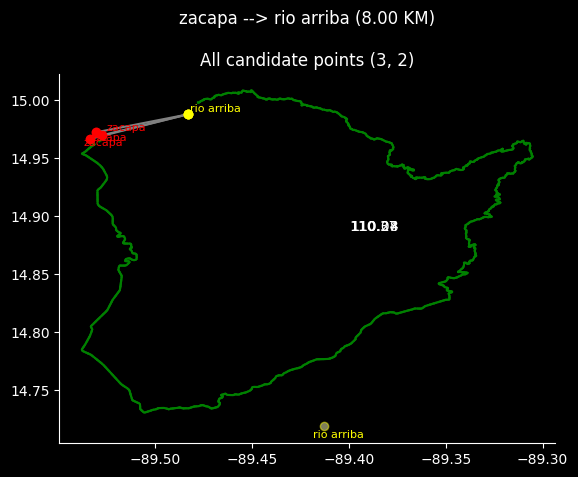

straight line distances [5.388983978277494, 5.887337001628721, 5.158790189744434]


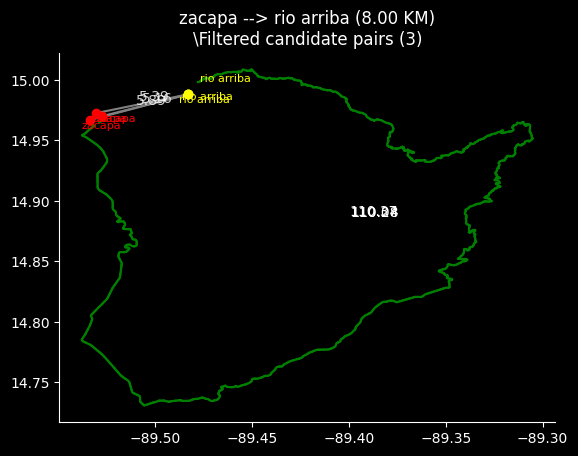

candidate route lengths [110.084432 110.236147 110.370637]


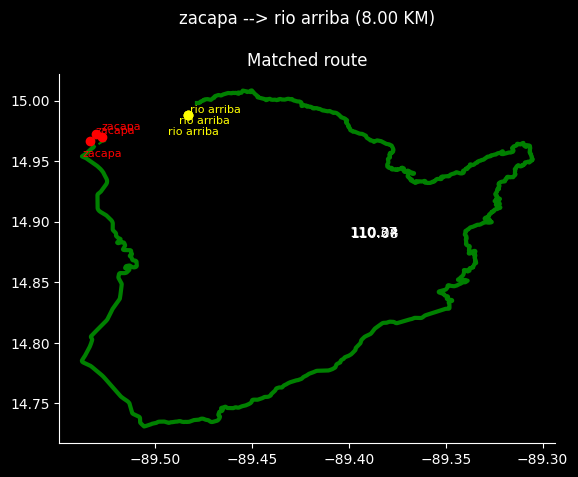

In [224]:
# p1, p2 = 'bifurcacion agua tibia', 'amatillo'
p1, p2 = 'zacapa', 'rio arriba'
# p1, p2 = 'agua chiquita', 'tuila'
# p1, p2 = 'secoyob', 'san luis'

info = debug(p1, p2)

In [ ]:
matches = []
with tqdm(df.itertuples(), total=len(df)) as bar:
    for i, row in enumerate(bar):
        wb_length = float(row.length)
        p1_name = row.endpoint_1
        p2_name = row.endpoint_2
        
        info = match(p1_name, p2_name, wb_length)
        if info.get('route') is None:
            continue
        matches.append(info)
    
        bar.set_postfix({
            'start': p1_name,
            'end': p2_name,
            'diff': info['diff'],
            'matches': len(matches)
        })
        gc.collect()

In [216]:
# with open('matches_20210607.pkl', 'rb') as f:
#     matches = pickle.load(f)

In [228]:
diffs = np.array([m['diff'] for m in matches if abs(m['diff']) < np.inf])
abs_diffs = np.abs(diffs)
rel_errs = np.array([m['rel_error'] for m in matches if abs(m['diff']) < np.inf])

In [229]:
nmatched = (abs_diffs <= 5).sum()
nmatched, nmatched / len(df)

(203, 0.6363636363636364)

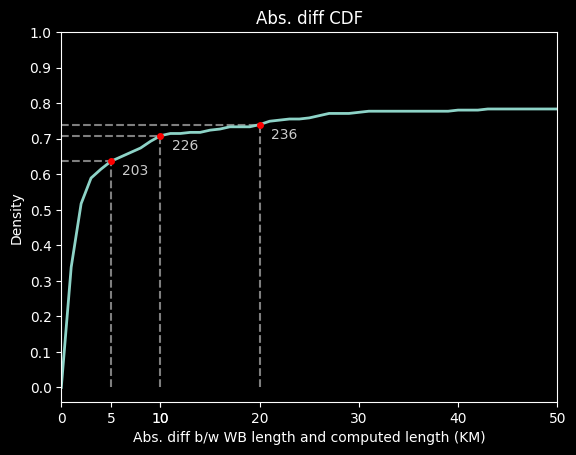

In [230]:
sorted_diffs = np.arange(100)
frac = np.array([(abs_diffs < d).sum() for d in sorted_diffs]) / len(df)
plt.plot(sorted_diffs, frac, linewidth=2)

for d in [5, 10, 20]:
    first_line = LineString(np.column_stack((sorted_diffs, frac)))
    second_line = LineString([(d, 0), (d, 1)])
    intersection = first_line.intersection(second_line)

    if intersection.geom_type == 'MultiPoint':
        intersection_x, intersection_y = np.array(LineString(intersection).xy)
    elif intersection.geom_type == 'Point':
        intersection_x, intersection_y = np.array(intersection.xy)

    plt.vlines(x=intersection_x, ymin=0, ymax=intersection_y, linestyle='--', alpha=0.5)
    plt.hlines(y=intersection_y, xmin=0, xmax=intersection_x, linestyle='--', alpha=0.5)
    plt.scatter(intersection_x, intersection_y, s=16, c='red', zorder=10)
    plt.annotate(f'{int(intersection_y*len(df))}', 
                 (intersection_x, intersection_y), 
                 (8, -10), 
                 textcoords='offset points',
                 alpha=0.8)

plt.xlim((0, 50))

plt.yticks(np.arange(0, 1.1, .1))
locs, _ = plt.xticks()
locs = np.array(locs, dtype=int).tolist() + [5, 10]
plt.xticks(locs, locs)

plt.ylabel('Density')
plt.xlabel('Abs. diff b/w WB length and computed length (KM)')
plt.title('Abs. diff CDF')
plt.show()

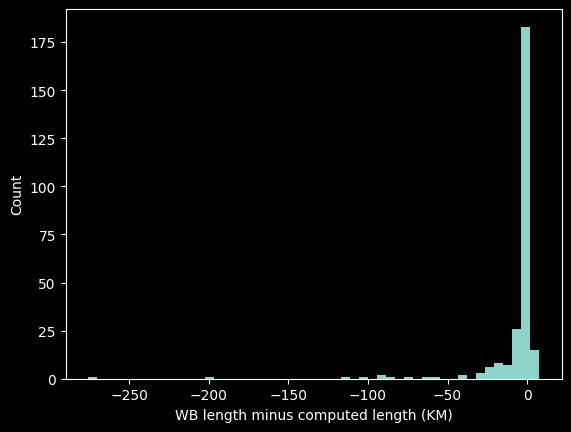

In [231]:
plt.hist(diffs, bins=50)
plt.xlabel('WB length minus computed length (KM)')
plt.ylabel('Count')
plt.show()

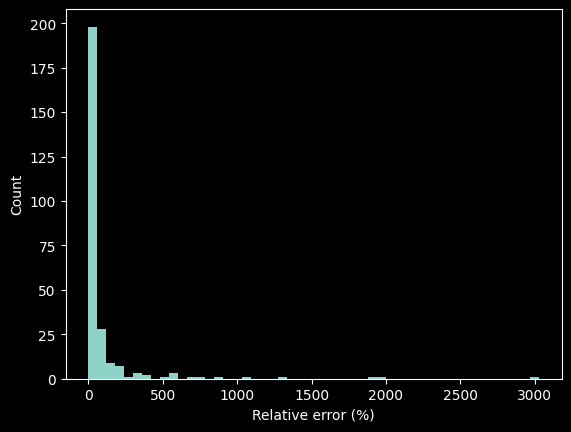

In [232]:
plt.hist(rel_errs[rel_errs < np.inf]*100, bins=50)
plt.xlabel('Relative error (%)')
plt.ylabel('Count')
plt.show()

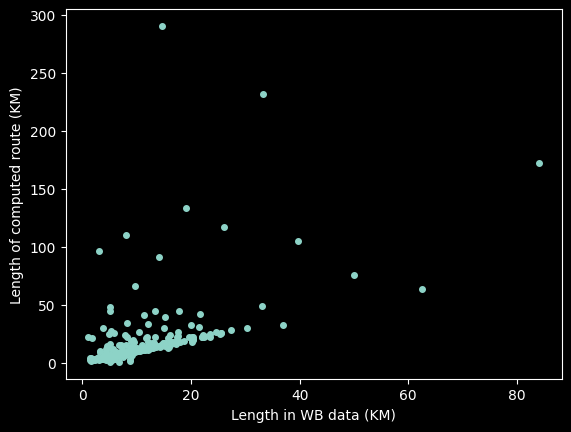

In [233]:
plt.scatter([m['wb_length'] for m in matches], [m['length'] for m in matches], s=16)
plt.xlabel('Length in WB data (KM)')
plt.ylabel('Length of computed route (KM)')
plt.show()

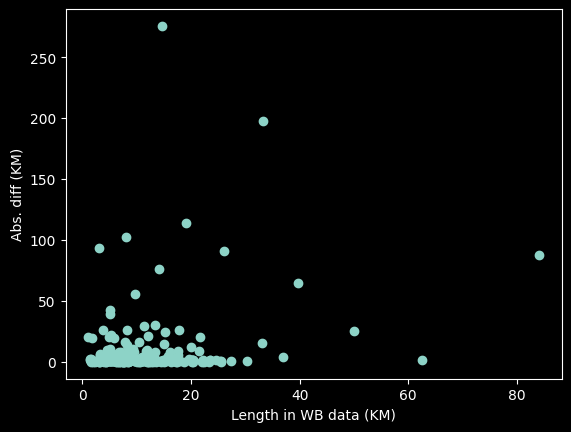

In [234]:
plt.scatter([m['wb_length'] for m in matches], [abs(m['diff']) for m in matches])
plt.xlabel('Length in WB data (KM)')
plt.ylabel('Abs. diff (KM)')
plt.show()

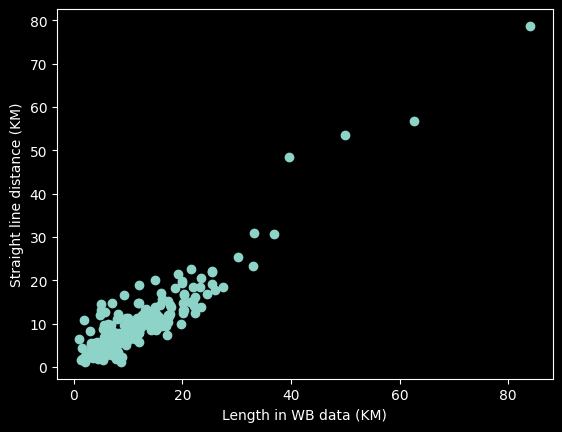

In [235]:
plt.scatter([m['wb_length'] for m in matches], [m['straight_line_dist'] for m in matches])
plt.xlabel('Length in WB data (KM)')
plt.ylabel('Straight line distance (KM)')
plt.show()

## Save matched routes

In [237]:
with open('matches_20210609.pkl', 'wb') as f:
    pickle.dump(matches, f)

In [277]:
matches_df = pd.DataFrame.from_records(matches)
matches_df = pd.merge(
    matches_df, 
    df[['endpoint_1', 'endpoint_2', 'iri']], 
    how='left', 
    left_on=['p1_name', 'p2_name'], 
    right_on=['endpoint_1', 'endpoint_2'])
matches_df

,p1_name,p2_name,wb_length,route,start_node,end_node,length,p1,p2,straight_line_dist,diff,abs_diff,rel_error,endpoint_1,endpoint_2,iri
0,puente belice,puente rodriguitos,4.470000,"[7007354523, 7007354524, 410394582, 7007354526...",7007354523,2205847309,6.186291,POINT (-90.48506 14.6493),POINT (-90.43796 14.64822),5.075209,-1.716291,1.716291,0.383958,puente belice,puente rodriguitos,5.80
1,la ruidosa,bifurcacion cayuga,14.890000,"[6120299581, 2640358756, 2640358754, 264035874...",6120299581,5443929616,16.573088,POINT (-88.82472 15.50231),POINT (-88.7 15.53333),13.814111,-1.683088,1.683088,0.113035,la ruidosa,bifurcacion cayuga,4.14
2,bifurcacion cayuga,bifurcacion el cimarron,9.800000,"[5443929616, 5443929617, 5443929618, 544392961...",5443929616,4230399264,11.059443,POINT (-88.7 15.53333),POINT (-88.63882 15.57858),8.254646,-1.259443,1.259443,0.128515,bifurcacion cayuga,bifurcacion el cimarron,4.56
3,puerto quetzal,puerto iztapa,9.750000,"[1234281918, 5945641524, 4611294368, 123428188...",1234281918,2027026324,9.088890,POINT (-90.78677 13.92057),POINT (-90.7075 13.93333),8.682100,0.661110,0.661110,0.067806,puerto quetzal,puerto iztapa,3.43
4,quezaltepeque,desvio a padre miguel,11.340000,"[5902851920, 2447404952, 5994807376, 599480737...",5902851920,8488722086,40.785912,POINT (-89.44241 14.63553),POINT (-89.45874999999999 14.56787),7.690471,-29.445912,29.445912,2.596641,quezaltepeque,desvio a padre miguel,4.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,samororo,mataquescuintla,17.299999,"[2412633166, 568946082, 568946083, 568946084, ...",2412633166,568948172,17.009219,POINT (-90.28001999999999 14.51392),POINT (-90.18416999999999 14.52917),10.468160,0.290780,0.290780,0.016808,samororo,mataquescuintla,5.59
256,el carrizal,san martineros,2.000000,"[1212171622, 1785632289, 1212168600, 178563239...",1212171622,2653871592,2.161157,POINT (-90.53767000000001 14.78315),POINT (-90.53522 14.77307),1.146083,-0.161157,0.161157,0.080579,el carrizal,san martineros,5.59
257,palencia,agua caliente,16.940001,"[2404113482, 2404003841, 2632503433, 290827192...",2404113482,2631192003,17.700292,POINT (-90.35720999999999 14.66715),POINT (-90.32743000000001 14.74701),9.400214,-0.760291,0.760291,0.044881,palencia,agua caliente,1.62
258,desvio san antonio sacatepequez,san marcos,7.250000,"[3931350531, 3931350554, 411199297, 1241088143...",3931350531,2002139708,9.204347,POINT (-91.73154 14.9606),POINT (-91.79443999999999 14.96389),6.775897,-1.954347,1.954347,0.269565,desvio san antonio sacatepequez,san marcos,3.50


In [278]:
matches_df.to_csv('matches_20210609.csv')

In [239]:
nodes, edges = ox.graph_to_gdfs(nx.MultiDiGraph(G))

In [265]:
def edges_to_geojson(edge_infos):
    features = []
    for info in edge_infos:
        f = {
            'type': 'Feature',
            'geometry': mapping(info['geometry']),
            'properties': {k: v for (k, v) in info.items() if k not in ['geometry']}
        }
        f['properties']['osmid'] = str(f['properties']['osmid'])
        f['properties']['oneway'] = str(f['properties']['oneway'])
        features.append(f)
    gjson = geojson.FeatureCollection(features)
    return gjson

In [266]:
root = './matched_routes_20210609'
os.makedirs(root, exist_ok=True)
wb_fields_to_include = ['iri']

with tqdm(matches) as bar:
    for m in bar:
        if m['route'] is None:
            continue
        p1_name = m['p1_name']
        p2_name = m['p2_name']
        route = m['route']
        edge_infos = [
            edges.loc[(u, v, 0)].to_dict()
            for u, v in zip(route[:-1], route[1:])
        ]
        
        
        wb_data = df[(df.endpoint_1 == p1_name) & (df.endpoint_2== p2_name)]
        wb_data = next(wb_data.itertuples(index=False))._asdict()
        wb_data = {k: wb_data[k] for k in wb_fields_to_include}
        for d in edge_infos:
            d.update(wb_data)

        gjson = edges_to_geojson(edge_infos)
        
        filename = f'{root}/{p1_name}--{p2_name} ({m["diff"]:.1f}, {m["rel_error"]:.1f}).json'
        bar.set_postfix({
            'filename': filename
        })
        with open(filename, 'w') as f:
            json.dump(gjson, f)


100%|██████████| 260/260 [00:37<00:00,  7.03it/s, filename=./matched_routes_20210609/nueva radial entre anillos--este (-12.1, 0.6).json]                   


0.0